# NCAA Division 1 Swimming Data Analysis

Kendrick McDonald

At both the Men's and Women's NCAA Division 1 Swimming Championships this March, as well as conference championships earlier in the season, it seemed like NCAA records were falling at an unprecedented rate. Some of the top performers achieved times I never thought I would see in my lifetime. Perhaps even more interesting, it seemed that the top end of the NCAA as a whole was improving at a faster rate than ever before. Kyle Sockwell, among others, has a name for this phenomenon: Swimflation.

I wondered what this pheonomenon really means and how we might measure it.

Swimming is an impressively quantifiable sport. 

On the individual level, there are:
- Finish times
- Event records
- Splits
- Stroke rates
- Underwaters
- Breathing patterns
- Reaction times

On the team level:
- Team points
- Team records
- Championship titles
- Championship-qualifying swimmers

There are many ways to study how swimming performance has changed over time. I decided to focus on the NCAA Division 1 level because short course yards is the fastest format in the sport and because I'm a former NCAA D1 swimmer myself. USA Swimming has a robust database of *individual* NCAA performances that are easy to download in csv format, making it easy to collect and analyze. *(Note: The USA Swimming forms did not include relay data.)*

I decided not to limit my analysis to performances from the championships but instead chose to include the top individual performances from any point in the season, in particular to account for swimmers who may have peaked at conference championships with extraordinary performances. I also collected data showing the progression of NCAA records over time, although it's unclear whether the USA Swimming database is as complete on this front as it is on the individual performance front, since it has fewer record breaking performances for each event in the format available for download.

Using top performance and record progression data, I can try to study Swimflation in several different ways:
- How have the top performances changed over time?
- How has the range of top performances (i.e. the difference between the 1st and 16th) changed over time?
- What do the distributions of top performances during different time periods look like?
- TK

This notebook will show how I can use usasw_scrape.py to collect data about top NCAA Division 1 swimming performances from the USA Swimming website, and then usasw_clean.py to clean the data and prepare it for analysis. 

In [1]:
# Import swimming scripts

from scripts import usasw_scrape_data, usasw_clean_data, usasw_plot_data

import scripts/usasw_clean_data import clean_ncaa_record_data
from scripts/usasw_clean_data import calculate_record_stats
from /scripts/usasw_scrape_data import get_NCAA_results, fill_out_form

# Import other libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
records = 'data/NCAA_Records.csv'
records = clean_ncaa_record_data(records)
records = calculate_record_stats(records)

In the process of cleaning NCAA record data, I've removed records broken by the same swimmer at the same meet in the same year. It could be the case that a dominant swimmer breaks a record during prelims and again in finals, and while that's an impressive feat, I think it's more important to consider the final record set during a particular meet.

Here's a sample of the data I collected:

In [20]:
records.sample(frac=0.05, random_state=23)

,name,distance,stroke,course,gender,time_(string),time_(seconds),date,season,team,...,meet,session,event_id,athlete_id,team_id,meet_id,record_broken_by,record_improvement_%,new_record_holder_broken_by,new_record_holder_improvement_%
132,Ella Eastin,200,IM,SCY,F,1:50.67,110.67,2018-03-15,2018.0,STAN,...,2018 NCAA DI - Women,Final,21,2773439,8528,62067,0.98,0.877743,1.10,0.975610
87,Caeleb Dressel,100,BR,SCY,M,50.03,50.03,2018-02-17,2018.0,FLOR,...,2018 SEC Champs,Final,15,1063976,8619,135562,0.01,0.019984,0.01,0.019980
72,Ryan Murphy,200,BK,SCY,M,1:35.73,95.73,2016-03-26,2016.0,CAL,...,2016 NCAA DI - Men,Final,13,2097441,8084,13430,1.04,1.074713,1.85,1.875887
106,Will Licon,200,BR,SCY,M,1:48.12,108.12,2016-03-26,2016.0,TEX,...,2016 NCAA DI - Men,Final,16,1630139,8157,13430,0.54,0.496963,NaN,NaN
143,Ella Eastin,400,IM,SCY,F,3:54.60,234.60,2018-03-16,2018.0,STAN,...,2018 NCAA DI - Women,Final,22,2773439,8528,62067,1.93,0.815964,1.93,0.809360
17,Arianna Vanderpool-Wallace,100,FR,SCY,F,46.61,46.61,2012-02-18,2012.0,AUB,...,2012 SEC Champs,,2,1241955,8288,14004,0.20,0.427259,0.20,0.425441
101,Breeja Larson,200,BR,SCY,F,2:04.48,124.48,2012-11-15,2013.0,TA&M,...,2012 UH Phill Hansel Inv,Prelim,16,120042,8597,22796,0.27,0.216433,0.27,0.215965
45,Peter Vanderkaay,500,FR,SCY,M,4:09.82,249.82,2005-03-24,2005.0,Div I,...,2005 NCAA DI - Men,,4,997346,7969,43809,NaN,NaN,NaN,NaN


### Missing Data

Something important to note before diving into the analysis is that nearly 1 in 5 records have no preceding value, meaning USA Swimming does not have the time beaten by the swimmer who set the record. This creates a floor for the possible analysis of record improvement.

In [21]:
total_records = records.shape[0]
early_records = records[['record_broken_by']].isna().sum()[0]

summary = pd.DataFrame({'Value': [total_records, early_records]},
                       index=['Total Records', 'Early Records'])
display(summary)

,Value
Total Records,154
Early Records,28


Because of this, I need to remove the earliest record performances from the data, since they won't have information in the 'record_broken_by' or 'record_improvement' data fields.

In [24]:
records = pd.read_csv('ncaa_record_progression.csv')

In [25]:
new_records = records[~records['record_broken_by'].isna()]

# Create new dataframes for all male and female records
male_records = records[records['gender'] == 'M']
female_records = records[records['gender'] == 'F']

# Create new dataframes for all new male and female records
male_new_records = male_records[~male_records['record_broken_by'].isna()]
female_new_records = female_records[~female_records['record_broken_by'].isna()]

## Frequency of Record-Breaking Swims

As a first step, I can create a dataframe that only includes the number of records broken in each season and use that to make a histogram. This will show how frequently records are broken in each season.

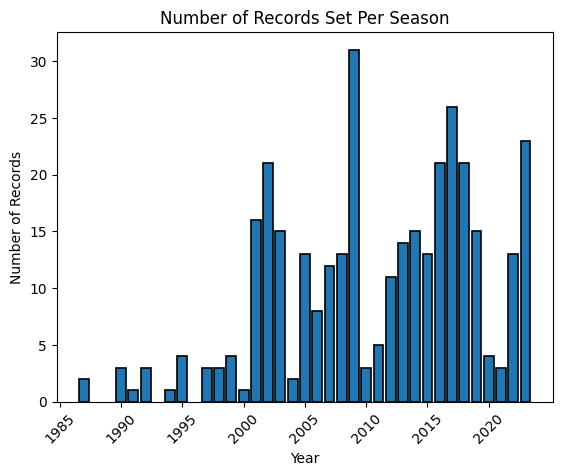

In [15]:
records_by_season = records.groupby('season').count().reset_index()
records_by_season = records_by_season[['season', 'name']].rename(columns={'name': 'count'}).sort_values('count', ascending=False)

bins = np.arange(1985,2025,5)

# Plot the histogram of the number of records per season
plt.bar(records_by_season['season'], 
            records_by_season['count'],
            edgecolor='black', 
            linewidth=1.2)
plt.xticks(bins, rotation=45, ha='center')
plt.xlabel("Year")
plt.ylabel("Number of Records")
plt.title("Number of Records Set Per Season")
plt.show()


Interestingly, the number of records broken in 2023 was only the fourth most in a season, according to the data USA Swimming has. One important note is that this doesn't account for relay records, all of which were broken in 2023.

### Male and Female Records

Let's look at the breakdown for men and women:

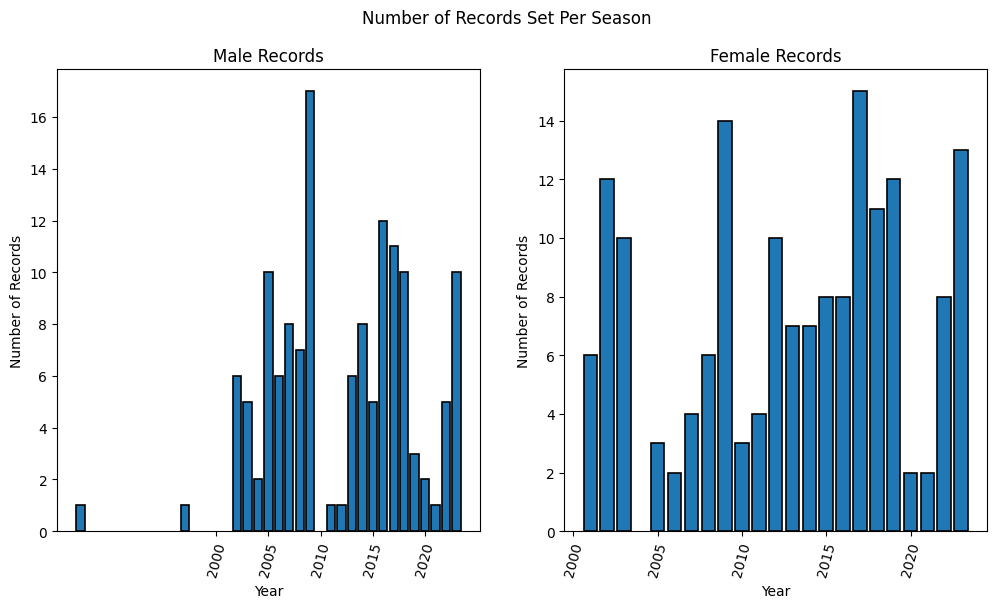

In [31]:
male_records_by_season = male_new_records.groupby('season').count().reset_index()
male_records_by_season = male_records_by_season[['season', 'name']].rename(
    columns={'name': 'count'}).sort_values('count', ascending=False)

female_records_by_season = female_new_records.groupby(
    'season').count().reset_index()
female_records_by_season = female_records_by_season[['season', 'name']].rename(
    columns={'name': 'count'}).sort_values('count', ascending=False)

bins = np.arange(2000, 2025,5)

# Create subplots for male and female record counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the histogram of the number of records per season
ax1.bar(male_records_by_season['season'],
        male_records_by_season['count'],
        edgecolor='black',
        linewidth=1.2)
ax1.set_xticks(bins)
ax1.set_xticklabels(bins, rotation=75, ha='center')
ax1.set_title('Male Records')
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of Records")

ax2.bar(female_records_by_season['season'],
        female_records_by_season['count'],
        edgecolor='black',
        linewidth=1.2)
ax2.set_xticks(bins)
ax2.set_xticklabels(bins, rotation=75, ha='center')
ax2.set_title('Female Records')
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of Records")

plt.suptitle("Number of Records Set Per Season")
plt.show()


### "Unique" Records

We can restrict this further by only considering truly "unique" records, i.e. each swimmer only setsone record per event per season. This means that if a swimmer breaks a record at conference championships and then again at the NCAA championships, only the latter record will be counted.

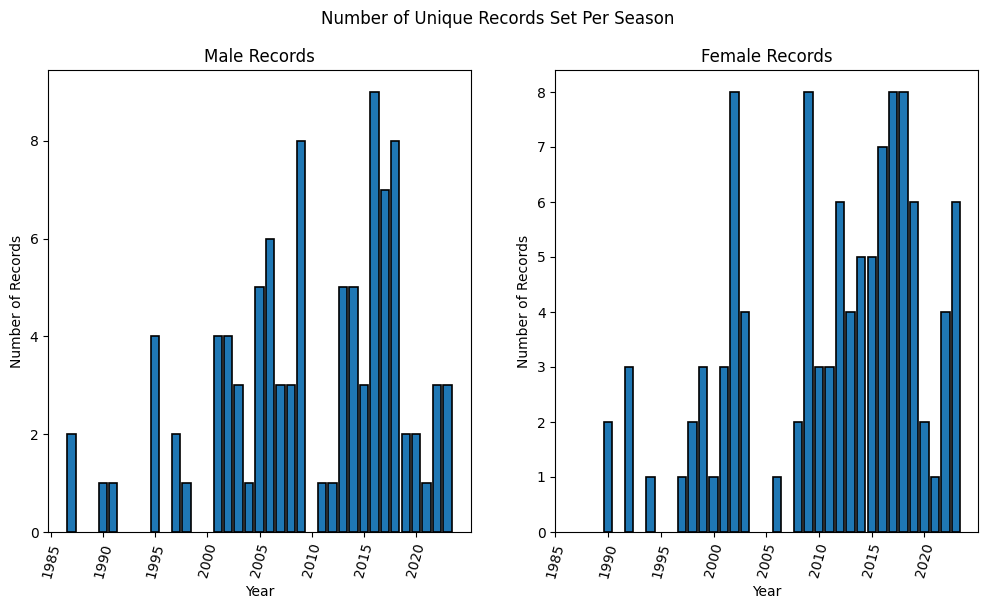

In [38]:
# Create a dataframe where each athlete_id and event_id can only appear once per season
unique_records = records.drop_duplicates(
    subset=['athlete_id', 'event_id', 'season'])
unique_records = unique_records[~unique_records['stroke'].str.contains('Relay')]
unique_records_by_season = unique_records.groupby(
    'season').count().reset_index()
unique_records_by_season = unique_records_by_season[[
    'season', 'athlete_id']].rename(columns={'athlete_id': 'unique_records'})

male_unique_records = male_records.drop_duplicates(
    subset=['athlete_id', 'event_id', 'season'])
male_unique_records = male_unique_records[~male_unique_records['stroke'].str.contains('Relay')]
male_unique_records_by_season = male_unique_records.groupby(
    'season').count().reset_index()
male_unique_records_by_season = male_unique_records_by_season[[
    'season', 'athlete_id']].rename(columns={'athlete_id': 'unique_records'})

female_unique_records = female_records.drop_duplicates(
    subset=['athlete_id', 'event_id', 'season'])
female_unique_records = female_unique_records[~female_unique_records['stroke'].str.contains('Relay')]
female_unique_records_by_season = female_unique_records.groupby(
    'season').count().reset_index()
female_unique_records_by_season = female_unique_records_by_season[[
    'season', 'athlete_id']].rename(columns={'athlete_id': 'unique_records'})

bins = np.arange(1985, 2025,5)

# Create subplots for male and female record counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the histogram of the number of records per season
ax1.bar(male_unique_records_by_season['season'],
        male_unique_records_by_season['unique_records'],
        edgecolor='black',
        linewidth=1.2)
ax1.set_xticks(bins)
ax1.set_xticklabels(bins, rotation=75, ha='center')
ax1.set_title("Male Records")
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of Records")

ax2.bar(female_unique_records_by_season['season'],
        female_unique_records_by_season['unique_records'],
        edgecolor='black',
        linewidth=1.2)
ax2.set_xticks(bins)
ax2.set_xticklabels(bins, rotation=75, ha='center')
ax2.set_title("Female Records")
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of Records")

plt.suptitle("Number of Unique Records Set Per Season")
plt.show()


## Record Improvement

The next question I want to consider is whether record improvement has been increasing over time. I can use the 'record_improvement' data field to answer this question, to visualize how much the average record improvement has changed by season.

,season,record_improvement_%
0,1987.0,0.000000
1,1997.0,1.122606
2,2002.0,0.240746
3,2003.0,0.438176
4,2004.0,1.584507
5,2005.0,0.768920
6,2006.0,0.608932
7,2007.0,0.393570
8,2008.0,0.599970
9,2009.0,0.459303


,season,record_improvement_%
13,2018.0,3.131868
14,2016.0,0.164564
15,2016.0,1.299404
16,2008.0,0.269978
17,2008.0,0.909577
...,...,...
337,2017.0,NaN
338,2016.0,NaN
339,2015.0,NaN
340,2009.0,NaN


In [59]:
male_record_improvement

,season,record_improvement_%
13,2018.0,3.131868
14,2016.0,0.164564
15,2016.0,1.299404
16,2008.0,0.269978
17,2008.0,0.909577
...,...,...
232,2017.0,0.503497
233,2014.0,0.685249
234,2009.0,0.940238
235,2009.0,0.055008


In [88]:
df = pd.DataFrame()
df[['season','record count']] = male_record_improvement.groupby('season').count().reset_index()
df['average improvement'] = male_record_improvement.groupby('season').mean().reset_index()['record_improvement_%']
df['total improvement'] = male_record_improvement.groupby('season').sum().reset_index()['record_improvement_%']
df.sort_values('total improvement', ascending=False)

,season,record count,average improvement,total improvement
15,2016.0,10,0.970086,9.700863
17,2018.0,8,1.023953,8.191628
9,2009.0,11,0.459303,5.052337
5,2005.0,6,0.768920,4.613519
22,2023.0,5,0.845073,4.225367
12,2013.0,5,0.747539,3.737695
16,2017.0,7,0.530032,3.710223
6,2006.0,6,0.608932,3.653590
8,2008.0,5,0.599970,2.999848
14,2015.0,4,0.666846,2.667383


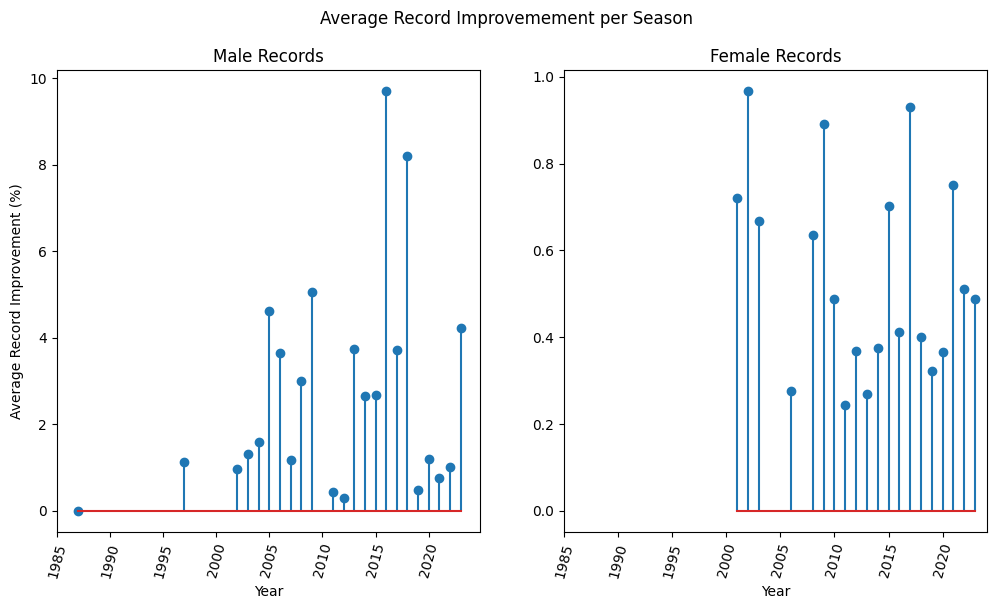

In [90]:
# Select dataframe with season, event_id, distance, stroke, and record_broken_by columns
male_record_improvement = male_new_records[['season', 'record_improvement_%']]
male_record_improvement = male_record_improvement.dropna()

# Group by season, event_id, distance, and stroke, and sum the record_broken_by column
# male_record_improvement = male_record_improvement.groupby(['season'])['record_improvement_%'].mean().reset_index()

# Select dataframe with season, event_id, distance, stroke, and record_broken_by columns
female_record_improvement = female_new_records[['season', 'record_improvement_%']]

# Group by season, event_id, distance, and stroke, and sum the record_broken_by column
female_record_improvement = female_record_improvement.groupby(['season'])['record_improvement_%'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the data
ax1.stem(df['season'],
df['total improvement'])
# , edgecolor='black',
# linewidth=1.2)
ax1.set_xticks(bins)
ax1.set_xticklabels(bins, rotation=75, ha='center')
ax1.set_xlabel("Year")
ax1.set_ylabel("Average Record Improvement (%)")
ax1.set_title("Male Records")

ax2.stem(female_record_improvement['season'],
female_record_improvement['record_improvement_%'])
# , edgecolor='black',
# linewidth=1.2)
ax2.set_xticks(bins)
ax2.set_xticklabels(bins,rotation=75, ha='center')
ax2.set_xlabel("Year")
ax2.set_title("Female Records")

plt.suptitle("Average Record Improvemement per Season")
plt.show()

## Top-16 Record-Setting Swims

Swim improvement is most often discussed in gross seconds rather than percentages. It may be surprising for some swim fans to see that some of the most dominant swim performances, like Leon Marchand's 400 I.M. at this year's NCAA championships, are lower than they might expect.

In [40]:
cols = ['name','distance','stroke','time_(string)','record_broken_by','record_improvement_%','season','meet']
rank = np.arange(1,17)
top_16 = new_records[cols].sort_values('record_improvement_%', ascending=False).head(16)
top_16.index = rank
top_16.index.name = 'Rank'
top_16.rename(columns={'name':'Athlete',
                       'distance':'Distance',
                       'stroke':'Stroke',
                       'time_(string)':'Time',
                       'record_broken_by': 'Seconds dropped',
                       'record_improvement_%':'Record Improvement (%)',
                       'season':'Season','meet':'Meet'}, inplace=True)
display(top_16)

,Athlete,Distance,Stroke,Time,Seconds dropped,Record Improvement (%),Season,Meet
Rank,,,,,,,,
1,Caeleb Dressel,50,FR,17.63,0.57,3.131868,2018.0,2018 NCAA DI - Men
2,Katie Ledecky,1650,FR,15:03.92,21.38,2.310602,2017.0,Ohio State Invitational
3,Natalie Coughlin,100,FL,50.01,1.17,2.286049,2002.0,NaN
4,Kevin Cordes,200,BR,1:48.68,2.05,1.851350,2013.0,2013 NCAA DI - Men
5,Clark Smith,1000,FR,8:33.93,9.55,1.824329,2016.0,Texas Swimming & Diving Hall
6,Caeleb Dressel,100,FL,42.80,0.78,1.789812,2018.0,2018 NCAA DI - Men
7,Elaine Breeden,200,FL,1:49.92,1.99,1.778215,2009.0,2009 PAC 10 Champs women
8,Katie Ledecky,1000,FR,9:10.49,9.66,1.724538,2017.0,Texas @ Stanford Women
9,Fred Bousquet,50,FR,18.74,0.31,1.627297,2005.0,NaN


The function below can be used to see the top n performances in a given season.

In [28]:
def get_top_n_swims(year, n):
    cols = ['name', 'distance', 'stroke',
            'time_(string)', 'record_broken_by','record_improvement_%', 'season', 'meet']
    rank = np.arange(1, n+1)
    top_n = new_records[new_records['season'] == year][cols].sort_values('record_improvement_%',
                                                                         ascending=False).head(min(n, len(new_records)))
    top_n.index = rank[:len(top_n)]
    top_n.index.name = 'Rank'
    top_n.rename(columns={'name': 'Athlete',
                          'distance': 'Distance',
                          'stroke': 'Stroke',
                          'time_(string)': 'Time',
                          'record_broken_by': 'Seconds dropped',
                          'record_improvement_%': 'Record Improvement (%)',
                          'season': 'Season', 'meet': 'Meet'}, inplace=True)
    return top_n

get_top_n_swims(2020, 10)

,Athlete,Distance,Stroke,Time,Seconds dropped,Record Improvement (%),Season,Meet
Rank,,,,,,,,
1,Bobby Finke,1650,FR,14:12.08,10.33,1.197806,2020.0,2020 SEC Champs
2,Abbey Weitzeil,50,FR,20.90,0.12,0.570885,2020.0,Minnesota Invite 2019


## Top Times by Season

Records are exciting but they're not the only way to measure improvement in swimming. I can also look at the top times in each event over the last several seasons. I'll confine my analysis to the 2012 - 2023 seasons (12 in total), since the 2020 season was incomplete due to the pandemic, and it's nicer to work with an even number of seasons for different analyses.

I'll start by using the scraping function I created to ingest and clean data for the top 16 performances in each event in each season. As any swimmer knows, 16 is the number of swimmers who qualify for the finals session at a championship meet -- 8 in the A final and 8 in the B final. I also chose to look at the top 16 times from any point in the season rather than at NCAA championships only, since conference championships are also incredibly competitive.

In [42]:
# Careful before running this cell since it will take ~7 minutes

early_results = {}
for year in range(2002, 2012):
    key = f"nc{year}"
    early_results[key] = get_NCAA_results(16, year)[0]

In [29]:
# Careful before running this cell since it will take ~7 minutes

results = {}
for year in range(2012, 2024):
    key = f"nc{year}"
    results[key] = get_NCAA_results(16, year)[0]

In [30]:
# Combine results into a single dataframe
nc_results = pd.concat(results, axis=0)

In [31]:
# Create a dataframe that shows the range of times for each event
nc_results_range = nc_results.groupby(['event','season'])['time_(seconds)'].agg(['min', 'max']).reset_index()
nc_results_range['range'] = nc_results_range['max'] - nc_results_range['min']

# Create a dataframe that shows the average time and standard deviation for each event
nc_results_avg = nc_results.groupby(['event','season'])['time_(seconds)'].mean().reset_index()
nc_results_avg.rename(columns={'time_(seconds)': 'average'}, inplace=True)
nc_results_avg['std'] = nc_results.groupby(['event','season'])['time_(seconds)'].std().reset_index()['time_(seconds)']

# Merge the two dataframes
nc_results_avg = nc_results_avg.merge(nc_results_range, on=['event','season'])
nc_results_avg['range_%_of_avg'] = nc_results_avg['range'] / nc_results_avg['min'] * 100

# Add Year over Year improvement in average time
nc_results_avg['avg_improvement_%'] = nc_results_avg.groupby('event')['average'].pct_change() * 100
nc_results_avg['min_improvement_%'] = nc_results_avg.groupby('event')['min'].pct_change() * 100
nc_results_avg['max_improvement_%'] = nc_results_avg.groupby('event')['max'].pct_change() * 100
nc_results_avg['range_improvement_%'] = nc_results_avg.groupby('event')['range'].pct_change() * 100

In [32]:
nc_results_avg.groupby('event')['avg_improvement_%'].mean().sort_values()

event
100 Butterfly SCY Male             -0.338353
100 Butterfly SCY Female           -0.312552
50 Freestyle SCY Male              -0.301789
100 Backstroke SCY Male            -0.295349
100 Freestyle SCY Male             -0.293177
100 Breaststroke SCY Male          -0.282090
200 Breaststroke SCY Male          -0.273412
200 Individual Medley SCY Male     -0.262089
200 Backstroke SCY Male            -0.261098
400 Individual Medley SCY Male     -0.259707
200 Freestyle SCY Male             -0.257153
100 Backstroke SCY Female          -0.236559
200 Butterfly SCY Male             -0.234273
1000 Freestyle SCY Male            -0.226541
200 Breaststroke SCY Female        -0.216099
100 Breaststroke SCY Female        -0.191853
200 Backstroke SCY Female          -0.191152
500 Freestyle SCY Male             -0.187227
50 Freestyle SCY Female            -0.182939
100 Freestyle SCY Female           -0.155557
200 Individual Medley SCY Female   -0.152910
200 Butterfly SCY Female           -0.143643
200 

In [33]:
# min event time improvement
total_min_event_improvement = nc_results_avg.groupby('event')['min_improvement_%'].mean()
early_min_event_improvement = nc_results_avg[nc_results_avg['season'] < 2017].groupby('event')['min_improvement_%'].mean()
late_min_event_improvement = nc_results_avg[nc_results_avg['season'] >= 2017].groupby('event')['min_improvement_%'].mean()

range_event_improvement = pd.concat([total_min_event_improvement,
                                        early_min_event_improvement,
                                        late_min_event_improvement], axis=1)
range_event_improvement.columns = ['2012-2023 min YoY Drop', '2012-2017 min YoY Drop', '2018-2023 min YoY Drop']
range_event_improvement = range_event_improvement.round(2)
range_event_improvement = range_event_improvement.sort_values('2018-2023 min YoY Drop')

# Highlight rows where 2018-2023 is greater than 2012-2017
range_event_improvement

,2012-2023 min YoY Drop,2012-2017 min YoY Drop,2018-2023 min YoY Drop
event,,,
100 Backstroke SCY Female,-0.37,-0.01,-0.58
200 Individual Medley SCY Male,-0.50,-0.46,-0.53
400 Individual Medley SCY Male,-0.43,-0.38,-0.47
200 Individual Medley SCY Female,-0.28,-0.02,-0.42
100 Breaststroke SCY Male,-0.23,-0.01,-0.36
100 Freestyle SCY Female,-0.19,0.06,-0.33
200 Backstroke SCY Female,-0.19,-0.03,-0.29
50 Freestyle SCY Female,-0.24,-0.16,-0.28
100 Butterfly SCY Female,-0.54,-1.00,-0.28


In [34]:
# Average event time improvement
total_average_event_improvement = nc_results_avg.groupby('event')['avg_improvement_%'].mean()
early_average_event_improvement = nc_results_avg[nc_results_avg['season'] < 2017].groupby('event')['avg_improvement_%'].mean()
late_average_event_improvement = nc_results_avg[nc_results_avg['season'] >= 2017].groupby('event')['avg_improvement_%'].mean()

average_event_improvement = pd.concat([total_average_event_improvement,
                                        early_average_event_improvement,
                                        late_average_event_improvement], axis=1)
average_event_improvement.columns = ['2012-2023 Average YoY Drop', '2012-2017 Average YoY Drop', '2018-2023 Average YoY Drop']
average_event_improvement = average_event_improvement.round(2)
average_event_improvement = average_event_improvement.sort_values('2018-2023 Average YoY Drop')

# Highlight rows where 2018-2023 is greater than 2012-2017
average_event_improvement


,2012-2023 Average YoY Drop,2012-2017 Average YoY Drop,2018-2023 Average YoY Drop
event,,,
100 Butterfly SCY Male,-0.34,-0.37,-0.32
100 Breaststroke SCY Male,-0.28,-0.27,-0.29
200 Breaststroke SCY Male,-0.27,-0.26,-0.28
50 Freestyle SCY Male,-0.30,-0.40,-0.25
100 Butterfly SCY Female,-0.31,-0.41,-0.25
100 Freestyle SCY Male,-0.29,-0.37,-0.25
100 Backstroke SCY Male,-0.30,-0.44,-0.22
200 Individual Medley SCY Male,-0.26,-0.34,-0.22
50 Freestyle SCY Female,-0.18,-0.13,-0.21


In [35]:
freestyle_events = nc_results_avg[nc_results_avg['event'].str.contains('Freestyle')]
male_freestyle_events = freestyle_events[freestyle_events['event'].str.contains('Male')]
female_freestyle_events = freestyle_events[freestyle_events['event'].str.contains('Female')]

backstroke_events = nc_results_avg[nc_results_avg['event'].str.contains('Backstroke')]
male_backstroke_events = backstroke_events[backstroke_events['event'].str.contains('Male')]
female_backstroke_events = backstroke_events[backstroke_events['event'].str.contains('Female')]

breaststroke_events = nc_results_avg[nc_results_avg['event'].str.contains('Breaststroke')]
male_breaststroke_events = breaststroke_events[breaststroke_events['event'].str.contains('Male')]
female_breaststroke_events = breaststroke_events[breaststroke_events['event'].str.contains('Female')]

butterfly_events = nc_results_avg[nc_results_avg['event'].str.contains('Butterfly')]
male_butterfly_events = butterfly_events[butterfly_events['event'].str.contains('Male')]
female_butterfly_events = butterfly_events[butterfly_events['event'].str.contains('Female')]

medley_events = nc_results_avg[nc_results_avg['event'].str.contains('Medley')]
male_medley_events = medley_events[medley_events['event'].str.contains('Male')]
female_medley_events = medley_events[medley_events['event'].str.contains('Female')]

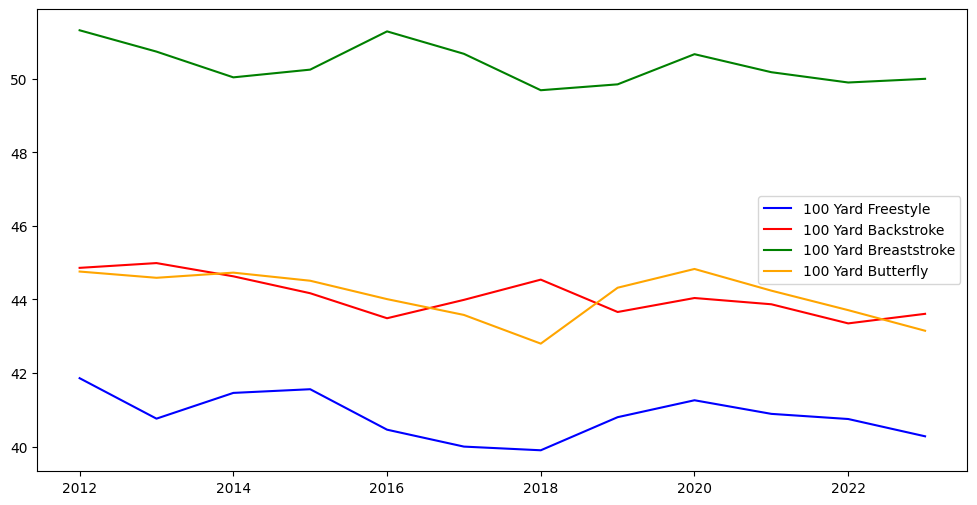

In [36]:
# Plot fastest times for male breaststroke events each year from 2012-2021 colored by event

fig = plt.figure(figsize=(12, 6));
seasons = np.arange(2012, 2024)

# Plot breaststroke events
x1 = seasons
y1 = male_freestyle_events[male_freestyle_events['event'] == '100 Freestyle SCY Male']['min']
y2 = male_backstroke_events[male_backstroke_events['event'] == '100 Backstroke SCY Male']['min']
y3 = male_breaststroke_events[male_breaststroke_events['event'] == '100 Breaststroke SCY Male']['min']
y4 = male_butterfly_events[male_butterfly_events['event'] == '100 Butterfly SCY Male']['min']
plt.plot(x1, y1, color='blue', label='100 Yard Freestyle')
plt.plot(x1, y2, color='red', label='100 Yard Backstroke')
plt.plot(x1, y3, color='green', label='100 Yard Breaststroke')
plt.plot(x1, y4, color='orange', label='100 Yard Butterfly')
plt.legend()
plt.show()

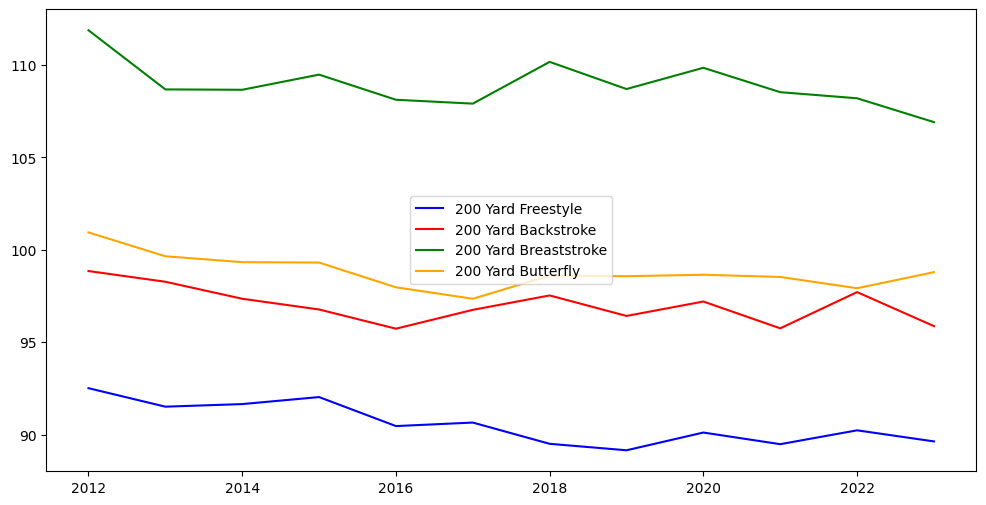

In [39]:
# Plot fastest times for male breaststroke events each year from 2012-2021 colored by event

fig = plt.figure(figsize=(12, 6));
seasons = np.arange(2012, 2024)

# Plot breaststroke events
x1 = seasons
y1 = male_freestyle_events[male_freestyle_events['event'] == '200 Freestyle SCY Male']['min']
y2 = male_backstroke_events[male_backstroke_events['event'] == '200 Backstroke SCY Male']['min']
y3 = male_breaststroke_events[male_breaststroke_events['event'] == '200 Breaststroke SCY Male']['min']
y4 = male_butterfly_events[male_butterfly_events['event'] == '200 Butterfly SCY Male']['min']
plt.plot(x1, y1, color='blue', label='200 Yard Freestyle')
plt.plot(x1, y2, color='red', label='200 Yard Backstroke')
plt.plot(x1, y3, color='green', label='200 Yard Breaststroke')
plt.plot(x1, y4, color='orange', label='200 Yard Butterfly')
plt.legend()
plt.show()